In [100]:
from helper import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Parameterized Function Approximator

Here, we will train simple Parameterized Likelihood Model on discrete 1D data to estimate the distribution

Dataset 1


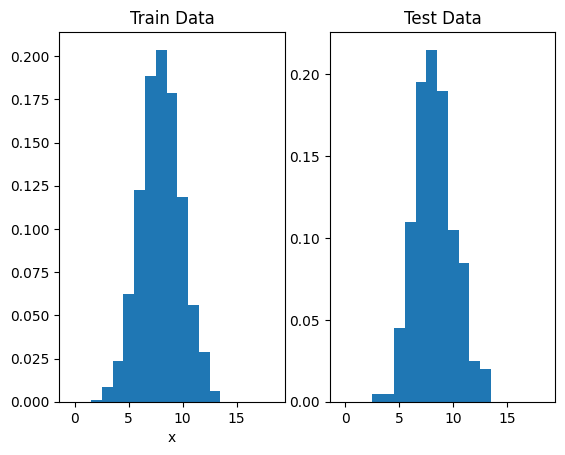

Dataset 2


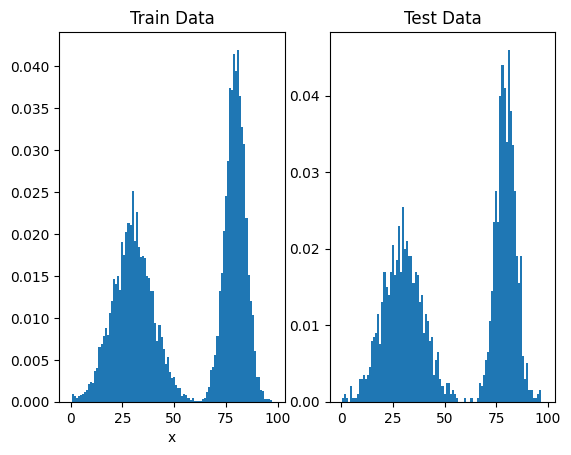

In [101]:
# Data Visualization
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{99}) \in \mathbb{R}^{100}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

We will fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. We will use our favorite version of stochastic gradient descent, and optimize the hyperparameters on a validation set.

Over the course of training we will track the following

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,99\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.


In [102]:
def train(model, train_loader, test_loader, optimizer, epoch):
    # train the model for one epoch
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.cuda()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, test_loader):
    # evaluate the model
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x = x.cuda()
            loss = model.loss(x)
            total_loss+=loss*x.shape[0]
        avg_loss = total_loss/len(test_loader.dataset)

    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = torch.optim.Adam(model.parameters(), lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        train_losses.extend(train(model, train_loader, test_loader, optimizer, epoch))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses
    




class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d), requires_grad=True) # initializing the parameters of the pdf to all 0's. There's one parameter for every bin

    def loss(self, x):
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
        return F.cross_entropy(logits, x.long())

    def get_distribution(self):
        distribution = F.softmax(self.logits, dim = 0) # array of size (d,) 
        return distribution.detach().cpu().numpy()

  

In [103]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=128)
    model = Histogram(d).cuda()

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=20, lr = 1e-1))
    distribution = model.get_distribution()
    return train_losses, test_losses, distribution

Epoch 0, Test loss 2.4074
Epoch 1, Test loss 2.1693
Epoch 2, Test loss 2.1011
Epoch 3, Test loss 2.0818
Epoch 4, Test loss 2.0738
Epoch 5, Test loss 2.0715
Epoch 6, Test loss 2.0749
Epoch 7, Test loss 2.0723
Epoch 8, Test loss 2.0683
Epoch 9, Test loss 2.0696
Epoch 10, Test loss 2.0629
Epoch 11, Test loss 2.0560
Epoch 12, Test loss 2.0549
Epoch 13, Test loss 2.0577
Epoch 14, Test loss 2.0569
Epoch 15, Test loss 2.0611
Epoch 16, Test loss 2.0657
Epoch 17, Test loss 2.0598
Epoch 18, Test loss 2.0582
Epoch 19, Test loss 2.0610


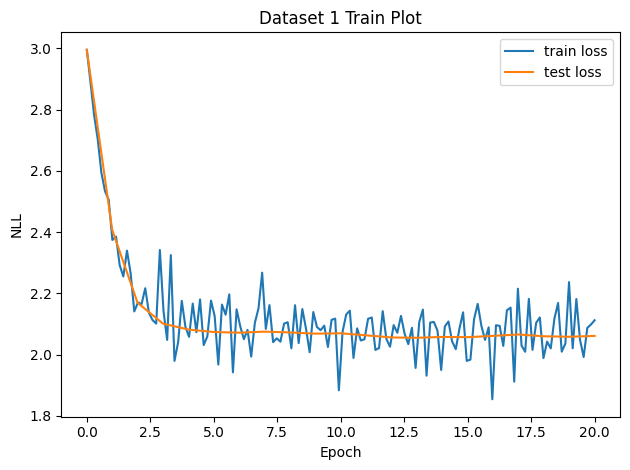

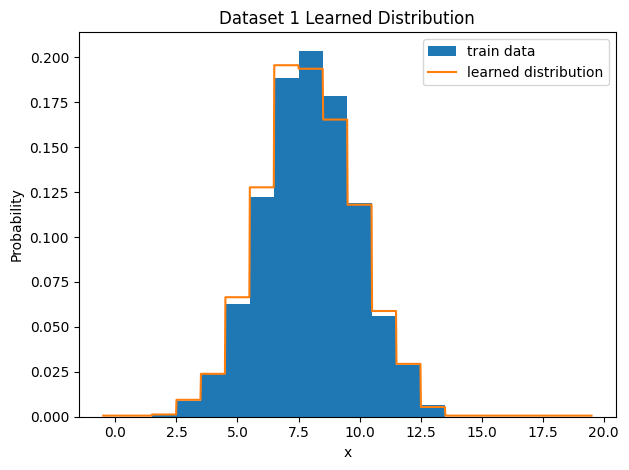

In [5]:
q1_save_results(1, 'a', q1_a)

Epoch 0, Test loss 4.0418
Epoch 1, Test loss 4.0488
Epoch 2, Test loss 4.0404
Epoch 3, Test loss 4.0449
Epoch 4, Test loss 4.0398
Epoch 5, Test loss 4.0397
Epoch 6, Test loss 4.0451
Epoch 7, Test loss 4.0455
Epoch 8, Test loss 4.0361
Epoch 9, Test loss 4.0410
Epoch 10, Test loss 4.0396
Epoch 11, Test loss 4.0494
Epoch 12, Test loss 4.0514
Epoch 13, Test loss 4.0475
Epoch 14, Test loss 4.0492
Epoch 15, Test loss 4.0485
Epoch 16, Test loss 4.0417
Epoch 17, Test loss 4.0456
Epoch 18, Test loss 4.0401
Epoch 19, Test loss 4.0387


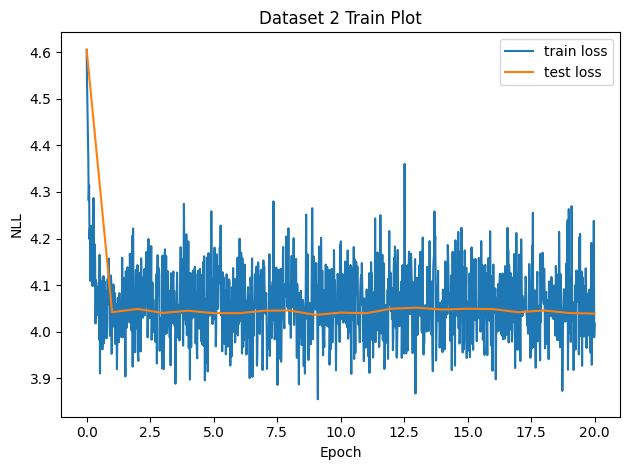

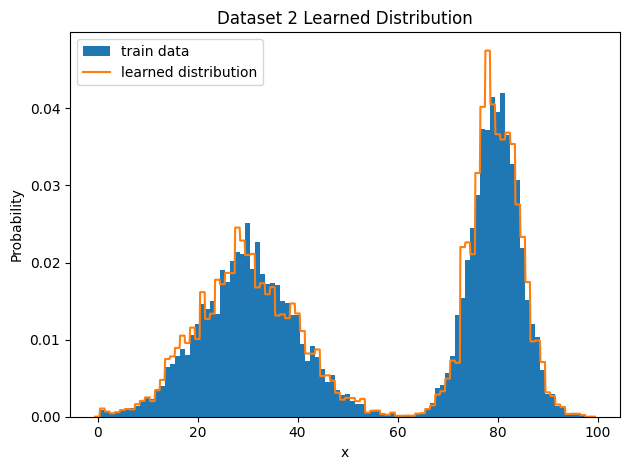

In [6]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.



In [7]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, n_mix=4):
        super().__init__()
        self.d = d # possible values that a random varoable can take
        self.n_mix = n_mix # total number of sigmoid
        
        self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True) # (n_mix,) - represents weights when calculating weight avg of logitsics
        self.means = nn.Parameter(torch.arange(n_mix).float()/(n_mix-1)*d, requires_grad=True) #(n_mix,)
        self.log_scales = nn.Parameter(torch.rand(n_mix), requires_grad=True) # (n_mix,)
        
    def forward(self, x):
        d = self.d
        x = x.float()
        x = x.unsqueeze(1).repeat(1, self.n_mix) # (b, n_mix) same numbers are copied n_mix times 
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # (1, n_mix)
        inv_scales = torch.exp(-log_scales)

        plus_in = inv_scales * (x + 0.5 - means) 
        min_in = inv_scales * (x - 0.5 - means)

        cdf_plus = torch.sigmoid(plus_in)
        cdf_min = torch.sigmoid(min_in)

        cdf_delta = cdf_plus - cdf_min # (b, 4). Every columns represent P(x) for one mixture of logistic
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min = 1e-12))
        log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)), 
                                                       min=1e-12)) # handle the case when x~0
        log_cdf_min = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * (d - 1.5 - means)),
                                        min=1e-12)) # handle the case when x = d-1

        x_log_probs = torch.where(x<0.001, log_cdf_plus, torch.where(x>d-1-1e-2, log_cdf_min, log_cdf_delta))
        pi_log_probs = F.log_softmax(self.logits, dim = 0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return torch.logsumexp(log_probs, dim=1) # log of likelihood

    def loss(self, x):
        return -torch.mean(self(x)) # - mean of log likelihood

    def get_distribution(self):
        with torch.no_grad():
            x = torch.FloatTensor(np.arange(self.d)).cuda()
            distribution = self(x).exp()
        return distribution.detach().cpu().numpy()
                                     
        

In [8]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    model = MixtureOfLogistics(d, n_mix=4).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-1))
    distribution = model.get_distribution()

    return train_losses, test_losses, distribution

Epoch 0, Test loss 2.5205
Epoch 1, Test loss 2.2012
Epoch 2, Test loss 2.1148
Epoch 3, Test loss 2.0923
Epoch 4, Test loss 2.0923
Epoch 5, Test loss 2.0736
Epoch 6, Test loss 2.0637
Epoch 7, Test loss 2.0677
Epoch 8, Test loss 2.0721
Epoch 9, Test loss 2.0721


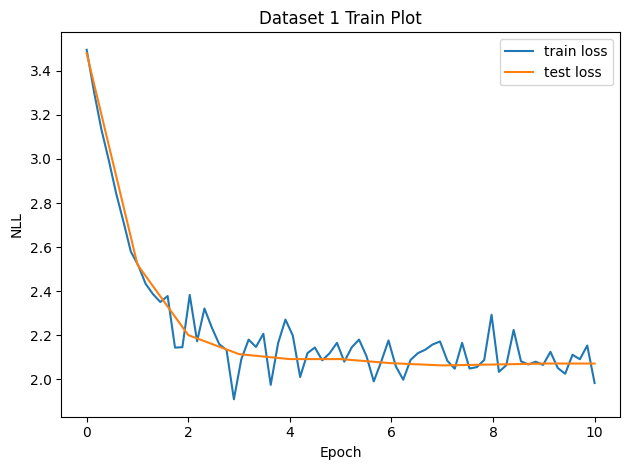

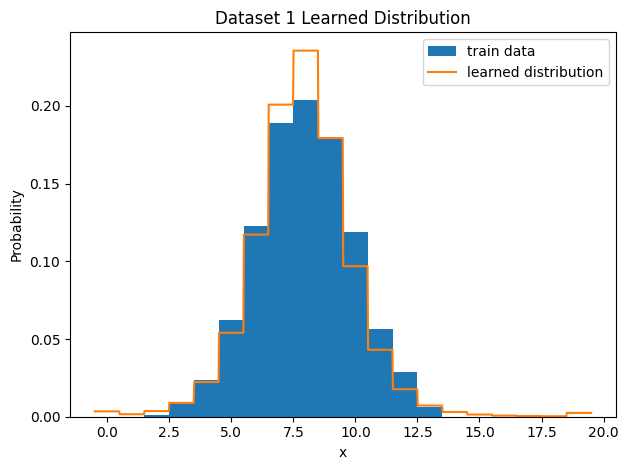

In [9]:
q1_save_results(1, 'b', q1_b)

Epoch 0, Test loss 4.4199
Epoch 1, Test loss 4.1989
Epoch 2, Test loss 4.0417
Epoch 3, Test loss 4.0420
Epoch 4, Test loss 4.0439
Epoch 5, Test loss 4.0396
Epoch 6, Test loss 4.0395
Epoch 7, Test loss 4.0413
Epoch 8, Test loss 4.0480
Epoch 9, Test loss 4.0391


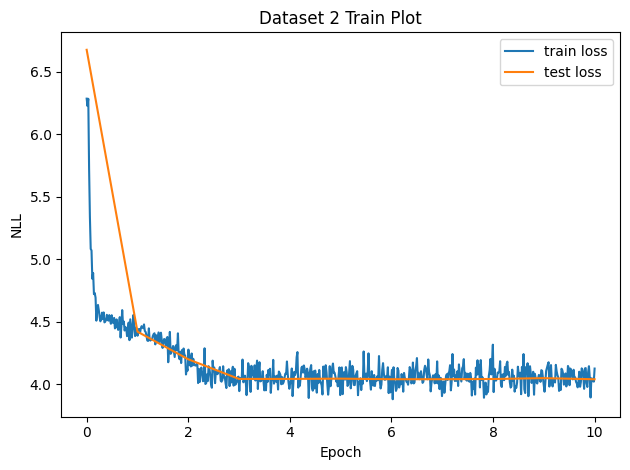

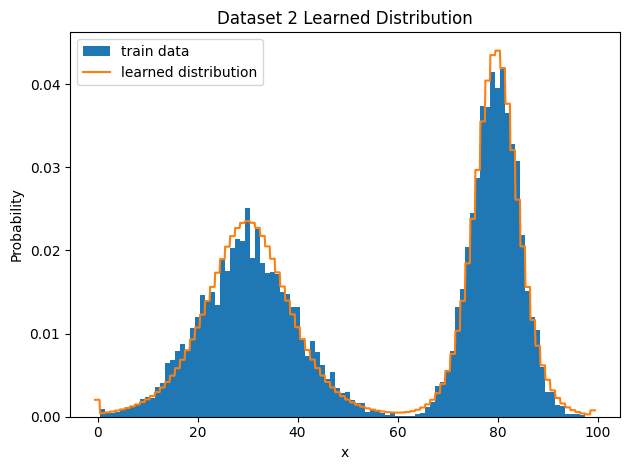

In [10]:
q1_save_results(2, 'b', q1_b)

# Masked Autoencode for Distribution Estimation (MADE)

Here we will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, we will use MADE to model a simple 2D joint distribution, and in the second half, we will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, we will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram.

Over the course of training we will track the following

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


Dataset 1


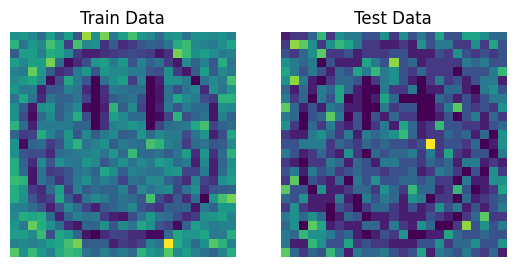

Dataset 2


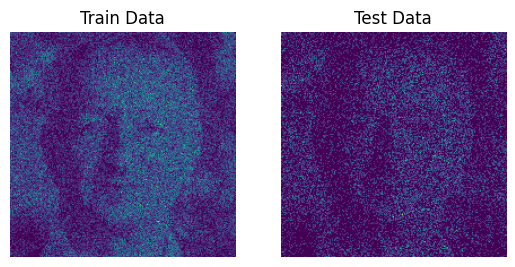

In [11]:
# visualize data
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

In [12]:
def to_one_hot(labels, d):
    # one hot encoding of labels
    
    one_hot = torch.FloatTensor(labels.shape[0], d).cuda() # (bs*nin, d)
    one_hot.zero_() # initizalize to all zeros
    
    # for every row in one_hot, it sets the one of the cols as 1. That col no. = labels[row_number]
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot # (bs*nin, d)

# Code based one Andrej Karpathy's implementation: https://github.com/karpathy/pytorch-made
class MaskedLinear(nn.Linear): 
    # Implementation of Masked NN
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias) # note the base class is nn.Linear which takes in_features, out_features, bias as input
        self.register_buffer('mask', torch.ones(out_features, in_features)) # 'mask' is not trained

    def set_mask(self, mask):
        # sasving mask attribute for each masked layer
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        # Forward propagation with masking
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, input_shape, d, hidden_size=[512, 512, 512], 
               ordering=None, one_hot_input=False):
        super().__init__()
        self.input_shape = input_shape # (2,)
        self.nin = np.prod(input_shape) # 2
        self.nout = self.nin * d # 50
        self.d = d # 2
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin) if ordering is None else ordering
        self.one_hot_input = one_hot_input

        # define a simple MLP neural net
        self.net = []
        
        # Given the number of hidden units, create a NN 
        hs = [self.nin * d if one_hot_input else self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):            
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
                ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        # Mask generation to satisfy autoregressive property
        
        L = len(self.hidden_sizes) # 2

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = self.ordering # m = {-1: array([0, 1])}
        
        '''
        We add a tag to every neuron from hidden layer 1 to output layer. 
        
        For the hidden layers, if a particular neuron has a tag of let's say 2 it implies that the particular 
        neuron expects information flow from input neuron 0, 1, 2. 
        
        For the output layer, if a particular neuron has a tag of let's say 2 it implies that the particular 
        neuron expects information from input neurons 0, 1.
        
        Tag generation:
        Input neurons are tagged from 0, 1,...,len(input_neurons)-1
        For every neuron in every hidden layer, we sample an interger from 0 (inclusive) and len(input_neurons) - 1 (exclusive). 
        This ensures that any neuron in any hidden layer doesn;t have an information flow from last input neuron (as expected
        from autoregressive models)
        
        Mask Generation:
        Once we have the tags for every neuron in every hidden layer, 
        
        1. For connections between input to hidden layer and hidden to hidden layer
        is done based on the tag from the present and nect layer. For eg, if a neuron in the next layer has a tag of say 1, 
        (i.e. it's expecting information flow from input neurons 0, 1) then connection from neurons with tag as 1 from previous 
        layer is kept and all the connections with a tag of >=2 is masked out. 
        
        2. For connections between the hidden layer and output layer, for 0th neuron in the output layer we allow 
        connections from the neurons in the previous layer with tag < 0. Similarly for 2nd neuron in the output layer we allow 
        connections from the neurons in the previous layer with tag < 2 (i.e. allowing information flow from input neurons 0 and 1).
        
        This ensures that we have auto regressive nature of the model.    
        '''
        
        # Generating tag for neurons in each hidden layer
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l])
        
        # construct the mask matrices for input to hidden and hidden to hidden connections
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        
        # construct the mask matrices for last hidden to output connections
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        # Since we take softmax across different possible values for an output, we expand the mask matrices
        # to (n_out *  d (possible number of values) for each output value)
        masks[-1] = np.repeat(masks[-1], self.d, axis=1)
        
        # Doing a similar thing at the input to accommodate oen hot encoding for the input
        if self.one_hot_input:
            masks[0] = np.repeat(masks[0], self.d, axis=0)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        
        # seeting mask for very layer
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        # x  = (bs, nin)
        batch_size = x.shape[0]
        if self.one_hot_input:
            x = x.long().contiguous().view(-1) # (bs*nin, )
            x = to_one_hot(x, self.d) #(bs*nin, d)
            x = x.view(batch_size, -1) # (bs, nin*d)
        else:
            x = x.float()
            x = x.view(batch_size, self.nin)
        logits = self.net(x).view(batch_size, self.nin, self.d)
        # (bs, d, nin) converting to the shape expected by k dim (here k = nin) cross entropy loss function. 
        # in the case of K-dimensional loss where each value should be between [0,C) and softmax is calculated individually across classes C 
        # for each dim
        return logits.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape) 

    def loss(self, x):
        # return loss for k dim cross entropy function
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        samples = torch.zeros(n, self.nin).cuda()
        self.inv_ordering = {x: i for i, x in enumerate(self.ordering)}
        with torch.no_grad():
            for i in range(self.nin):
                logits = self(samples).view(n, self.d, self.nin)[:, :, self.inv_ordering[i]]
                probs = F.softmax(logits, dim=1)
                samples[:, self.inv_ordering[i]] = torch.multinomial(probs, 1).squeeze(-1)
            samples = samples.view(n, *self.input_shape)
        return samples.cpu().numpy()

    def get_distribution(self):
        '''
        Once the model is trained, it will output P(x0) and P(x1/x0), where x0 and x1 are pixel positions. 
        Both will be the softmax probabilities of possible 25 values.
        
        So what we do here is we feed pixel positions (0,0), (0,1) .....(24, 24) one by one.
        We get logits for x0 and x1/x0. We get log probablities by calling log_softmax. We sum 
        and then take exp. With this we get P(x0, x1) i.e. probability that position x0 and x1 is sampled.
        we repeat this for every pixel position and return 25*25 probabilty distribution
        
        '''
        assert self.input_shape == (2,), 'Only available for 2D joint'
        
        '''
        Feed all pixel positions as input 
        x = tensor([[ 0,  0],
                    [ 0,  1],
                    [ 0,  2],
                    ...,
                    [24, 22],
                    [24, 23],
                    [24, 24]]
        '''
        
        x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
        x = torch.LongTensor(x).cuda()
        
        # log probabilities
        log_probs = F.log_softmax(self(x), dim=1) #(625, 25, 2) (bs, #classes, #dim)

        # gather logits for the corresponding pixel poisition i.e. true class
        distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1) #(625, 2)
         
        # sum of log probabilties
        distribution = distribution.sum(dim=1)

        # exp of log sum i.e. joint probabilities
        return distribution.exp().view(self.d, self.d).detach().cpu().numpy()

In [13]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    
    '''
    We are trying to estimate P(x1, x2) where x1 and x2 are the random variables the pixel location in an image. 
    We have an a greyscale image, for every pixel location we define the probabilty P(x0, x1) 
    as pixel value/sum of pixels in athe image. (Idea is pixel value at a particualr location 
    denotes the number of times x1=k1, x2=k2 is sampled.
    
    Training - 
    
    We sample x1 and x2 with pdf as explained before. We feed a sample of x1=k1 and x2=k2 to MADE.
    Output is of shape (bs, 25, 2), 25 represents different classes and 2 represent number of output dim (x1, x2).
    We maximize P(x1=k1) and P(x2=k2/x1=k1) at every epoch to guide the training
    
    '''
    
    model = MADE((2,), d, hidden_size=[100, 100], one_hot_input=True).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=2e-3))
    distribution = model.get_distribution() #(25*25) We stimate 25*25 probabilities
    
    return train_losses, test_losses, distribution

Epoch 0, Test loss 3.2108
Epoch 1, Test loss 3.1955
Epoch 2, Test loss 3.1874
Epoch 3, Test loss 3.1848
Epoch 4, Test loss 3.1817
Epoch 5, Test loss 3.1825
Epoch 6, Test loss 3.1813
Epoch 7, Test loss 3.1832
Epoch 8, Test loss 3.1819
Epoch 9, Test loss 3.1816
Epoch 10, Test loss 3.1821
Epoch 11, Test loss 3.1815
Epoch 12, Test loss 3.1830
Epoch 13, Test loss 3.1836
Epoch 14, Test loss 3.1831
Epoch 15, Test loss 3.1830
Epoch 16, Test loss 3.1813
Epoch 17, Test loss 3.1826
Epoch 18, Test loss 3.1827
Epoch 19, Test loss 3.1846
Final Test Loss: 3.1846


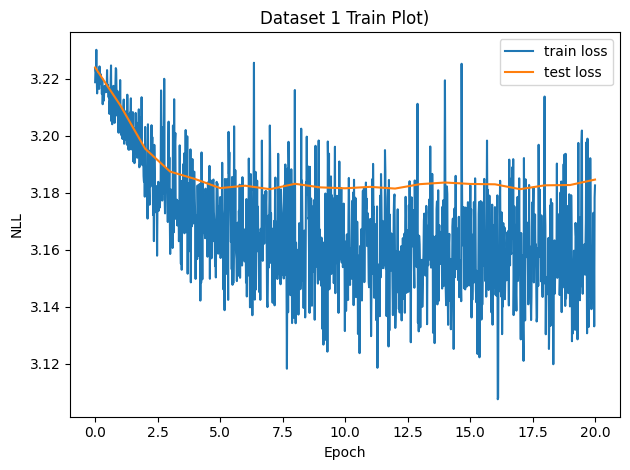

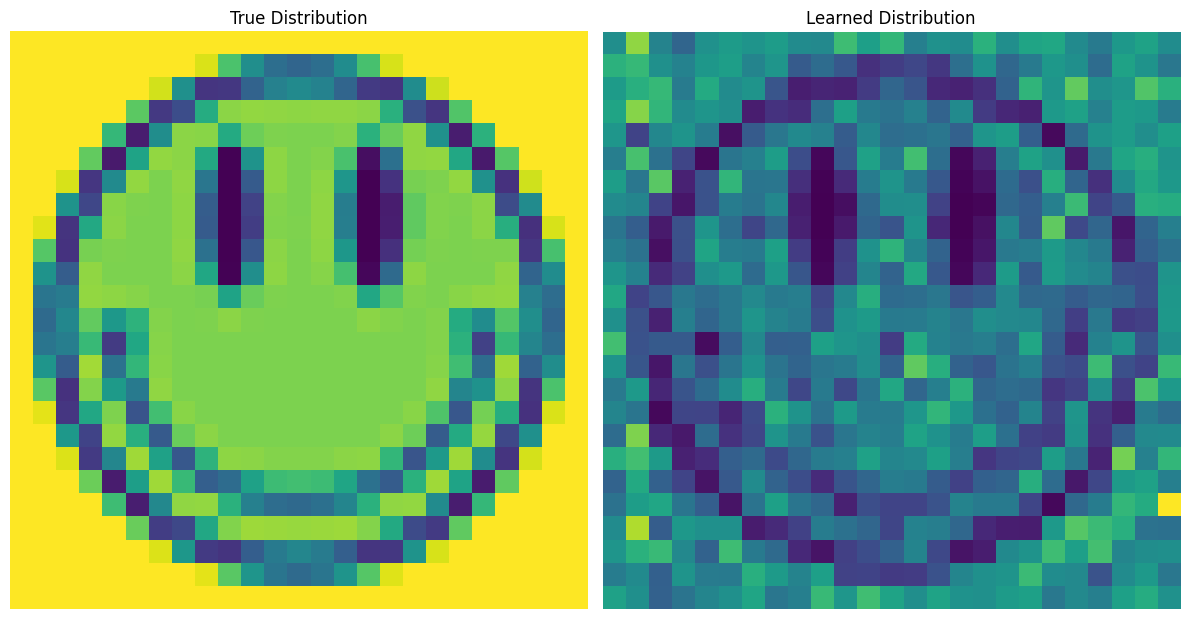

In [14]:
q2_save_results(1, 'a', q2_a)

Epoch 0, Test loss 5.2744
Epoch 1, Test loss 5.2687
Epoch 2, Test loss 5.2673
Epoch 3, Test loss 5.2706
Epoch 4, Test loss 5.2743
Epoch 5, Test loss 5.2777
Epoch 6, Test loss 5.2789
Epoch 7, Test loss 5.2827
Epoch 8, Test loss 5.2846
Epoch 9, Test loss 5.2883
Epoch 10, Test loss 5.2911
Epoch 11, Test loss 5.2915
Epoch 12, Test loss 5.2937
Epoch 13, Test loss 5.2938
Epoch 14, Test loss 5.2957
Epoch 15, Test loss 5.2958
Epoch 16, Test loss 5.2982
Epoch 17, Test loss 5.2994
Epoch 18, Test loss 5.2986
Epoch 19, Test loss 5.3012
Final Test Loss: 5.3012


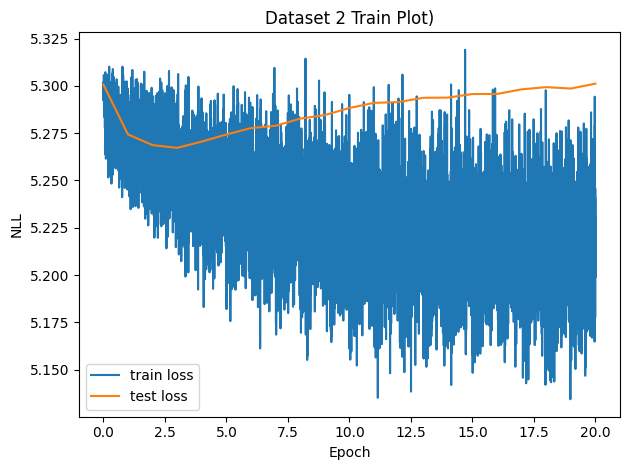

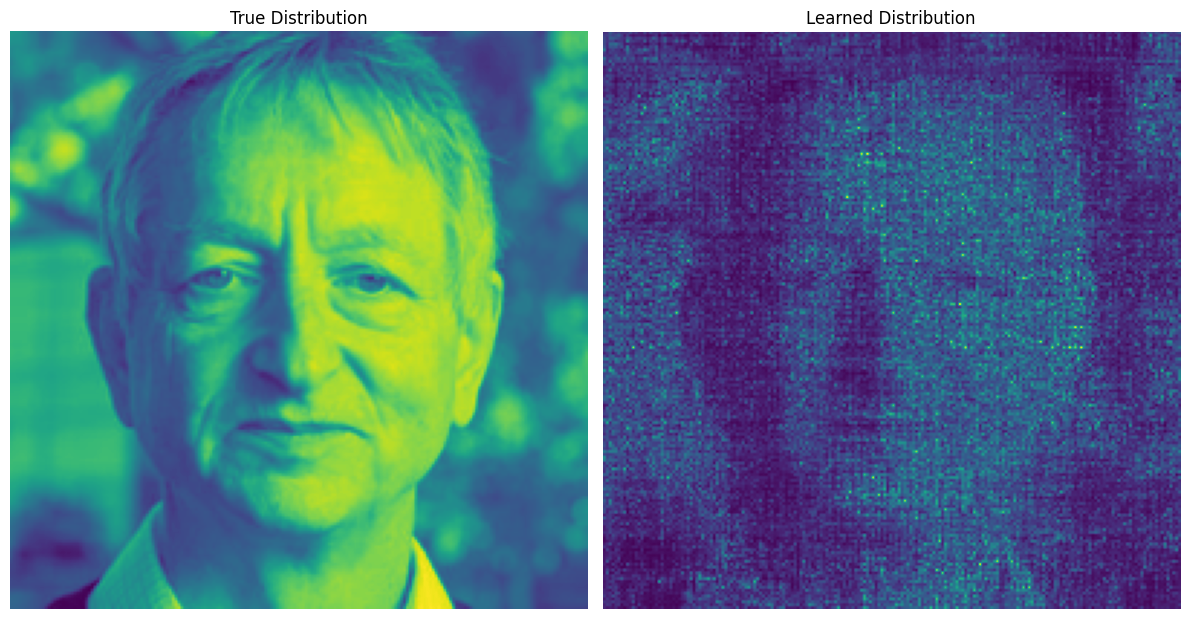

In [15]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

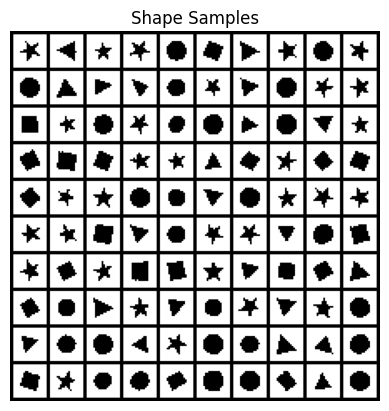

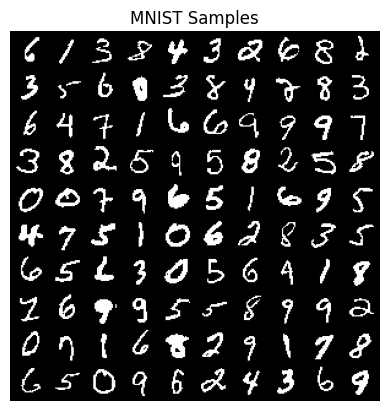

In [16]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. 

Over the course of training we will track the following


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [37]:
def q2_b(train_data, test_data, image_shape, dset_id):
    '''
    Training
    
    Similar to the one when we trained MADE with 2d data.
    
    Here we deal with a higher dimensional data d = (1, 20, 20). We flatten an image to 
    feed to MADE. We try to predict pixel values (either 0 or 1) given the previous pixel 
    values (Roster Scan). Shape of logits is 400, 2 where 2 is the number of clases.
    For loss, we calculate CE loss over two classes for every pixel seperately.
    
    Sampling
    
    Once the model is trained we also sample 100 instances from it. We feed a dummy input of
    shape 100*400 with all zeros to do the first forward pass. Logits shape is 100, 400, 2.
    For the first pixel, we sample a 0 or 1 based on binomial distribution outputed by the model.
    This is done for all 100 samples. 
    
    Now we reinitialize 100*400 input with first value initialized to the one sampled at the 
    previous step for every sample and repeat the above process.   
    
    '''
    
    train_data = np.transpose(train_data, (0, 3, 1, 2)) # (num_samples, 1, H. W)
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    
    
    H, W = image_shape
    model = MADE((1, H, W), 2, hidden_size=[512, 512]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=20, lr=1e-3))
    
    samples = model.sample(100)
    samples = np.transpose(samples, (0, 2, 3, 1))
    return train_losses, test_losses, samples

Epoch 0, Test loss 0.1744
Epoch 1, Test loss 0.1381
Epoch 2, Test loss 0.1197
Epoch 3, Test loss 0.1075
Epoch 4, Test loss 0.0985
Epoch 5, Test loss 0.0926
Epoch 6, Test loss 0.0868
Epoch 7, Test loss 0.0820
Epoch 8, Test loss 0.0786
Epoch 9, Test loss 0.0754
Epoch 10, Test loss 0.0734
Epoch 11, Test loss 0.0709
Epoch 12, Test loss 0.0694
Epoch 13, Test loss 0.0681
Epoch 14, Test loss 0.0671
Epoch 15, Test loss 0.0661
Epoch 16, Test loss 0.0649
Epoch 17, Test loss 0.0642
Epoch 18, Test loss 0.0633
Epoch 19, Test loss 0.0629
Final Test Loss: 0.0629


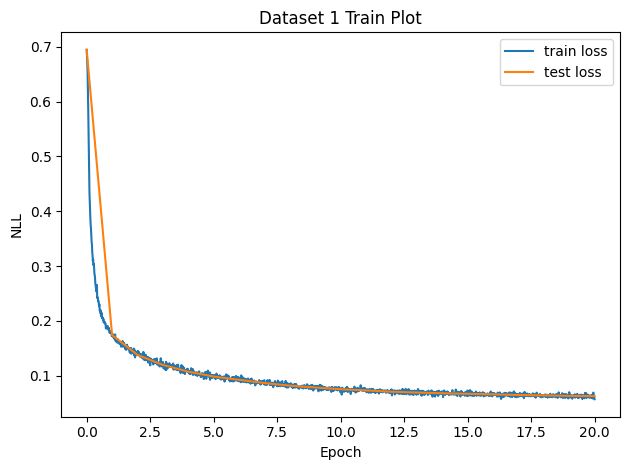

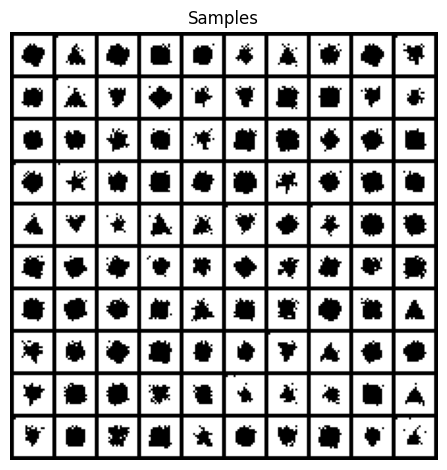

In [18]:
q2_save_results(1, 'b', q2_b)

Epoch 0, Test loss 0.1838
Epoch 1, Test loss 0.1486
Epoch 2, Test loss 0.1345
Epoch 3, Test loss 0.1272
Epoch 4, Test loss 0.1232
Epoch 5, Test loss 0.1206
Epoch 6, Test loss 0.1182
Epoch 7, Test loss 0.1163
Epoch 8, Test loss 0.1150
Epoch 9, Test loss 0.1145
Epoch 10, Test loss 0.1134
Epoch 11, Test loss 0.1127
Epoch 12, Test loss 0.1122
Epoch 13, Test loss 0.1116
Epoch 14, Test loss 0.1112
Epoch 15, Test loss 0.1112
Epoch 16, Test loss 0.1106
Epoch 17, Test loss 0.1102
Epoch 18, Test loss 0.1104
Epoch 19, Test loss 0.1102
Final Test Loss: 0.1102


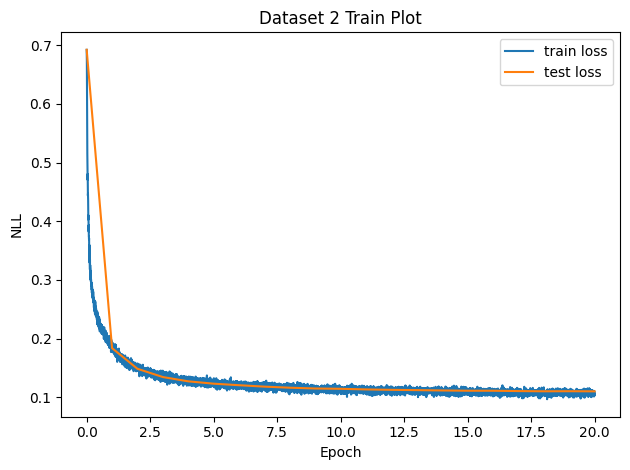

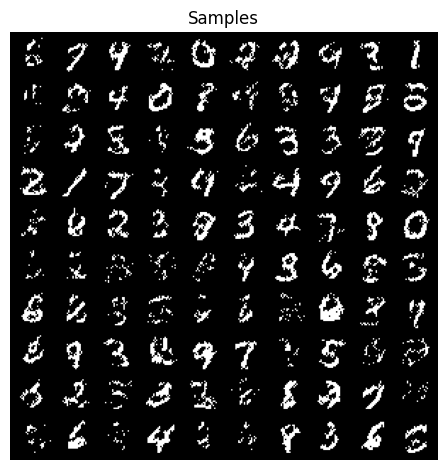

In [19]:
q2_save_results(2, 'b', q2_b)

# PixelCNNs

Now, we will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.

## Part (a) PixelCNN on Shapes and MNIST
In this part, we implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Part (b) for MADE, but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Our model would output logits, after which we could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Over the course of training

1. We will record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. We woll report the final test set performance of your final model
3. 100 samples from the final trained model



In [104]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, 
                 color_conditioning=False, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        
        # For 1st layer (input layer)
        # args = (in_channels, out_channels) --> (1, 64) for Part a, d and (3, 120) for Part b, kwargs = (7, 3)=(kernal_size, padding)
        
        # For subsequent layers
        # args = (in_channels, out_channels) --> (64, 64) for Part A and (120, 120) for Part b, kwargs = (7, 3)=(kernal_size, padding)
        # padding added to retain the size of feature map to 20 x 20 /28 x 28
        
        # When called from ResBlock() class
        # args = (120, 60, 1), kwargs = {} for ResBlock
        super().__init__(*args, **kwargs) # initializes a conv2d layer with --> in_channels=args[0], out_channels=args[1], kernel_size=7, padding=3 for Part A
        self.conditional_size = conditional_size # None
        self.color_conditioning = color_conditioning # False for Part a and b, True for Part c
        self.register_buffer('mask', torch.zeros_like(self.weight)) # self.weight is an atrribute of nn.Conv2d with shape (out_channels, in_channels, kernel_size[0], kernel_size[1])
        self.create_mask(mask_type)
        if self.conditional_size: # None for Part a, b, c, 4 or 10 for d
            if len(self.conditional_size)==1: # True 
                self.cond_op = nn.Linear(conditional_size[0], self.out_channels) # class conditioning - at every conv layer a linear layer that transforms (bs, n_classes) to (bs, out_channel for that conv layer)
            else:
                self.cond_op = nn.Conv2d(conditional_size[0], self.out_channels, 
                                         kernel_size=3, padding=1)
        
    def forward(self, input, cond=None):
        # cond = None for Part a, be, c
        # cond: (bs, 4) or (bs, 10) contains one hot encoded class labels of the batch
        '''
        Eg:
         tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],
        '''
        
        batch_size = input.shape[0]
        # applies masked conv2d (multiples weight with mask) - rest of the parameters 
        # are attributes of nn.Conv2d() class
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if self.conditional_size: # None for Part a, b, c, 4 or 10 for d
            if len(self.conditional_size) == 1:
                out = out + self.cond_op(cond).view(batch_size, -1, 1, 1) # broadcasts the class conditionnig output to the same spatial domension and adds 
            else:
                out = out + self.cond_op(cond)
        return out
    
    def create_mask(self, mask_type):
        k = self.kernel_size[0] # 7 x 7
        
        '''
        This creates a type A mask - prevents info flow from the pixel location [3, 3]
        which model is trying to predict
        
        [[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]
        '''
        self.mask[:, :, :k//2] = 1
        self.mask[:, :, k//2, :k//2] = 1
        
        if self.color_conditioning: # False for Part a, b and d, True for Part c
            assert self.in_channels%3 == 0 and self.out_channels%3 == 0
            # divide the input_channels and number of kernels in 3
            one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
            if mask_type == 'B':
                # Take first 1/3rd of kernels, for every kernel take 1/3rd channels and make center pixel = 1, 
                # for the res fo the channels it's 0
                self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
                # Take 2nd 1/3rd of kernels, for every kernel take first and second 1/3rd channels and make 
                # center pixel = 1. For the foirst 1/3rd kernels, second and third 1/3rd channels centre pixel is 0
                self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
                # Take 3rd 1/3rd of kernels, for every kernel take allchannels and make center pixel = 1. For 
                # the first 1/3rd kernels, second and third 1/3rd channels centre pixel is 0. For the second 1/3rd kernels, third 1/3rd channels centre pixel is 0
                self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
            else:
                # lly for Mask A
                
                # For first 1/3rd of kernels, center pixel = 0 for all the channels in every kernel
                
                # For second 1/3rd of kernels, center pixel = 1 for the channels < 1/3rd of channels
                self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
                # For third 1/3rd of kernels, center pixel = 1 for the channels < 2/3rd of channels                
                self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
        else:
            if mask_type == 'B':
                
                '''
                Type B mask: has the info flow from pixel location [3, 3] which model is 
                trying to predict
                
                [[1., 1., 1., 1., 1., 1., 1.],
                [1., 1., 1., 1., 1., 1., 1.],
                [1., 1., 1., 1., 1., 1., 1.],
                [1., 1., 1., 1., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0.]]
                '''                
                self.mask[:, :, k//2, k//2] = 1

class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        # in_channels = 120 
        super().__init__()
        # one Residual block with Type B Mask conv2d 
        self.block = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d('B', in_channels, in_channels // 2, 1, **kwargs), 
            nn.ReLU(), 
            MaskConv2d('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs),
            nn.ReLU(), 
            MaskConv2d('B', in_channels // 2, in_channels, 1, **kwargs)
        ])
        
    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond)
            else:
                out = layer(out)
        return out + x # adds the input to the output of residual block
    
class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        
        # color_conditioning = False, args = # output_filters, kwargs = {}
        super().__init__(*args, **kwargs) # initializes LayerNorm with no. of output filters
        self.color_conditioning = color_conditioning
        
    def forward(self, x):

        # x: (bs, channels, h, w)
        
        x = x.permute(0, 2, 3, 1).contiguous() # (bs, h, w, ch) 
        x_shape = x.shape
        if self.color_conditioning: # True for Part c and false for Part a and b
            x = x.contiguous().view(*(x_shape[:-1] + (3, -1))) # (bs, h, w, 3, ch/3)
        # layer norm across channels i.e for every pixel location, normalize across channels
        x = super().forward(x) # (bs, h, w, 3, ch/3) for part c # (bs, h, w, ch)  for part a and b
        if self.color_conditioning:
            x = x.view(*x_shape) # ((bs, h, w, ch)            
        return x.permute(0, 3, 1, 2).contiguous()

class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, n_filters=64, 
                 kernel_size=7, n_layers=5,
                 conditional_size=None, use_resblock=False, 
                 color_conditioning=False):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0] # 1 for Part a and 3 for Part b and c
        # n_colors = 2 for Part a, 4 for Part b and c # possible values of a pixel --> 0, 1 for Part a and 0, 1, 2, 3 for Part b
        #n_filters = 64 for Part a and 120 for Part b and c
        
        # {'conditional_size': None, 'color_conditioning': False} for Part a and b
        # {'conditional_size': None, 'color_conditioning': True} for Part c
        # {'conditional_size': 4 or 10, 'color_conditioning': False} for Part d
        kwargs = dict(conditional_size=conditional_size,
                      color_conditioning=color_conditioning)
        
        # if backbone has residual network
        if use_resblock: # False for Part a and d, True for Part b and c
            # creates a lambda function block_init for ResBlock (not called here)
            block_init = lambda: ResBlock(n_filters, **kwargs)
        else:
            # creates a lambda function block_init for MaksConv2d, function (not called here), 
            # parameters passed are the parameters for Conv layer
            block_init = lambda: MaskConv2d('B', n_filters, n_filters, 
                                            kernel_size=kernel_size, 
                                           padding=kernel_size // 2, **kwargs)
            
        # Create a Masked conv layer of type A (and append to the model) both for Part a, Part b, Part c, Part d
        model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters,
                                          kernel_size=kernel_size,
                                          padding=kernel_size // 2, **kwargs)])
        
        # n_layers = 5  for Part a, d 
        # n_layers = 8 for Part b and c     
        
        # After adding one Type A Masked Conv2d layer, it adds n_layers of 
        # (LayerNorm, ReLU, Type B Masked Conv2d layer) for Part A and D
        # (LayerNorm, ReLU, ResBlock) for Part B and C. 
        #For part C we do layer norm for every group of channels seperately
        
        for _ in range(n_layers):
            if color_conditioning: # False for Part a, b and d, True for Part c
                model.append(LayerNorm(color_conditioning, n_filters // 3))
            else:
                model.append(LayerNorm(color_conditioning, n_filters))
            model.extend([nn.ReLU(), block_init()])
            
        # At the end it adds
        # two Type B Masked Conv2d layer for Part a, Part b, Part c and Part d
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1, **kwargs)])
        
        # Part a 
        # last conv layer outputs (bs, 2, 20, 20) where 2 represents the logit scores for two possible
        # pixel values at every pixel location
        
        # Part b, c, d 
        # last conv layer outputs (bs, 12, 20, 20) where 12 is 3*4 -> represents the logit scores for 4 possible
        # pixel values at every pixel location at each channel
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_colors * n_channels, 1, **kwargs)]) 
        
        if conditional_size: # None for Part a, b, c and 4 or 10 for Part d
            if len(conditional_size) == 1:
                self.cond_op = lambda x: x
            else:
                self.cond_op = nn.Sequential(
                    nn.Conv2d(1, 64, 3, padding=1), 
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1), 
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1), 
                    nn.ReLU()
                )
                
        self.net = model
        self.input_shape = input_shape
        self.n_colors = n_colors # 2 for Part a and d and 4 for Part b, c
        self.n_channels = n_channels # 1 for Part a, d and 3 for Part b, c
        self.color_conditioning = color_conditioning # False for Part a, b and True for Part c
        self.conditional_size = conditional_size # None for Part a, b, c and 4 or 10 for Part d
        
    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) /0.5
        if self.conditional_size: # None for Part a, b, c and 4 or 10 for Part d
            cond = self.cond_op(cond) # passes x without any transformation
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        if self.color_conditioning: # False for Part a, b andd,  True for Part c
            # Part c
            # last conv layer outputs (bs, 4, 3, 20, 20) where 4 represents the logit scores for four possible
            # pixel values at every pixel location
            return out.view(batch_size, self.n_channels, self.n_colors,
                            *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
        else:
            # Part a
            # last conv layer outputs (bs, 2, 1, 20, 20) where 2 represents the logit scores for two possible
            # pixel values at every pixel location
            
            # Part b
            # last conv layer outputs (bs, 4, 3, 20, 20) where 4 represents the logit scores for four possible
            # pixel values at every pixel location
            return out.view(batch_size, self.n_colors, *self.input_shape)

    def loss(self, x, cond=None):
        return F.cross_entropy(self(x, cond=cond), x.long())
    
    # sampling logic for color independent autoregressive model
    def sample(self, n, cond=None):
        # zero tensor of shape (100, 1, 20, 20)
        samples = torch.zeros(n, *self.input_shape).cuda() 
        # sample values at every pixel location for every channel one by one 
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    out = self(samples, cond=cond) # we feed the tensor of all zeros
                    # for every channel look at the predicted probability for the pixel location and sample a pixel value for all the channels
                    for k in range(self.n_channels):
                        logits = out[:, :, k, r, c]                        
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()
    
    # sampling logic for color dependent aurtoregressive model
    def sample_channel_dependent(self, n, cond=None):
        # zero tensor of shape (100, 1, 20, 20)
        samples = torch.zeros(n, *self.input_shape).cuda() 
        # sample values at every pixel location for every channel one by one 
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        # for partocular pixel location, do forward pass as many times as
                        # no. of channels since the pixel value at a particular channel depends on pixel values from all the previous channels
                        logits = self(samples, cond=cond)[:, :, k, r, c]
                        
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()
                
                

In [105]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
  
    train_data = np.transpose(train_data, (0, 3, 1, 2)) # (bs, nc, h, w) --> (10479, 1, 20, 20)_
    test_data = np.transpose(test_data, (0, 3, 1, 2)) # (bs, nc, h, w) --> (4491, 1, 20, 20)_    

    H, W = image_shape #(20, 20)
    model = PixelCNN((1, H, W), 2, n_layers=5).cuda()

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))
    samples = model.sample(100)
    return train_losses, test_losses, samples
     

Epoch 0, Test loss 0.1504
Epoch 1, Test loss 0.1138
Epoch 2, Test loss 0.0901
Epoch 3, Test loss 0.0633
Epoch 4, Test loss 0.0527
Epoch 5, Test loss 0.0471
Epoch 6, Test loss 0.0450
Epoch 7, Test loss 0.0432
Epoch 8, Test loss 0.0425
Epoch 9, Test loss 0.0409
Final Test Loss: 0.0409


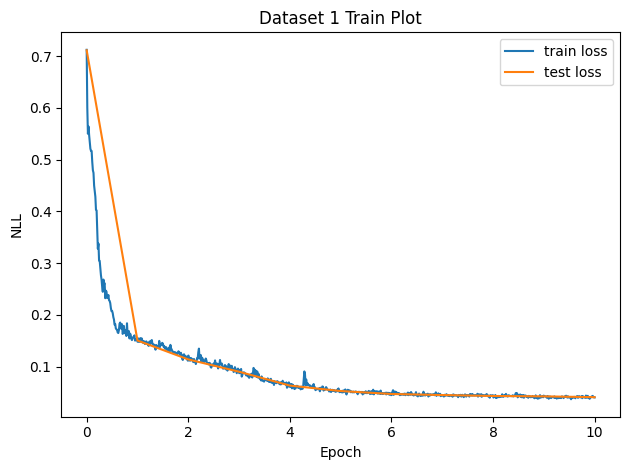

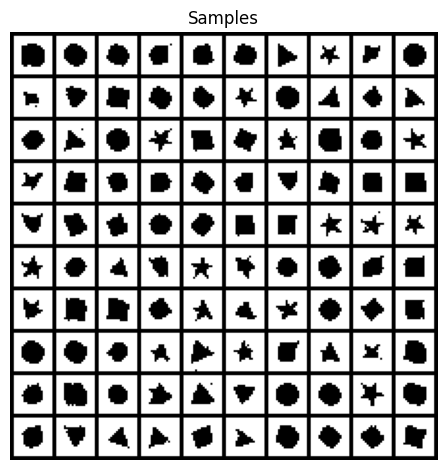

In [64]:
q3a_save_results(1, q3_a)

Epoch 0, Test loss 0.0839
Epoch 1, Test loss 0.0796
Epoch 2, Test loss 0.0781
Epoch 3, Test loss 0.0790
Epoch 4, Test loss 0.0769
Epoch 5, Test loss 0.0767
Epoch 6, Test loss 0.0761
Epoch 7, Test loss 0.0758
Epoch 8, Test loss 0.0754
Epoch 9, Test loss 0.0756
Final Test Loss: 0.0756


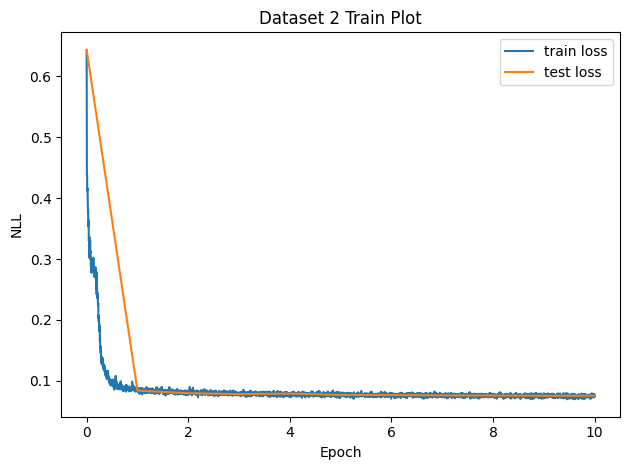

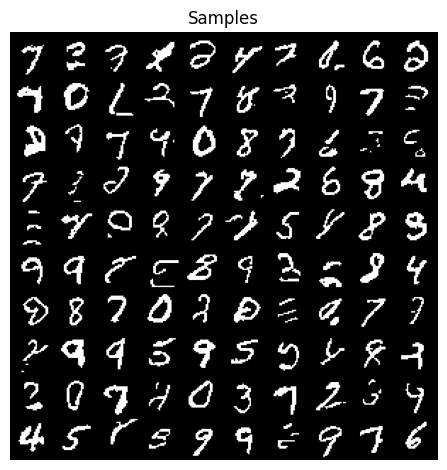

In [65]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

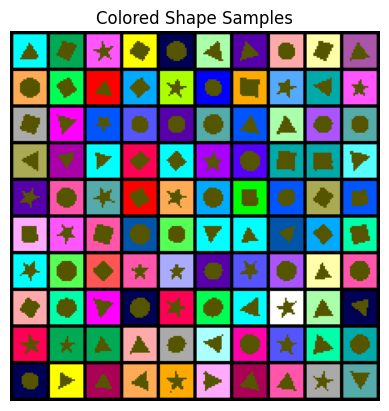

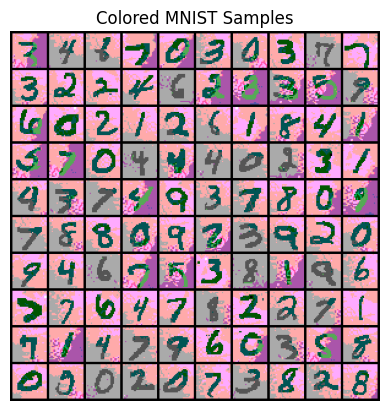

In [66]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, we will implement a PixelCNN to support RGB color channels. **First, we implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

* We will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* We can set number of filters for each convolutions to 120. We can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

Over the course of training we will, 

1. record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set).
2. report the final test set performance of your final model
3. sample 100 samples from the final trained model



In [67]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """
    
    #(bs, 3, 20, 20) with possible pixel values at every location being 0, 1, 2, 3
    train_data = np.transpose(train_data, (0, 3, 1, 2)) 
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W, C = image_shape
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, use_resblock=True).cuda()
    train_args = dict(epochs=15, lr=1e-3, grad_clip=1)

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)
    samples = model.sample(100)
    return train_losses, test_losses, samples
     

Epoch 0, Test loss 0.1208
Epoch 1, Test loss 0.0820
Epoch 2, Test loss 0.0808
Epoch 3, Test loss 0.0672
Epoch 4, Test loss 0.0636
Epoch 5, Test loss 0.0596
Epoch 6, Test loss 0.0545
Epoch 7, Test loss 0.0515
Epoch 8, Test loss 0.0522
Epoch 9, Test loss 0.0479
Epoch 10, Test loss 0.0468
Epoch 11, Test loss 0.0451
Epoch 12, Test loss 0.0460
Epoch 13, Test loss 0.0436
Epoch 14, Test loss 0.0426
Final Test Loss: 0.0426


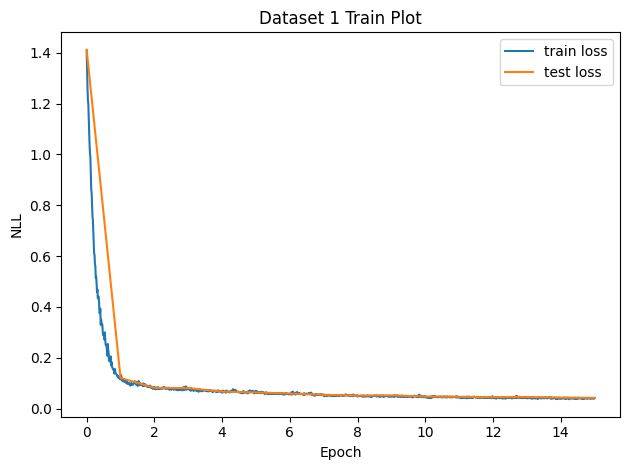

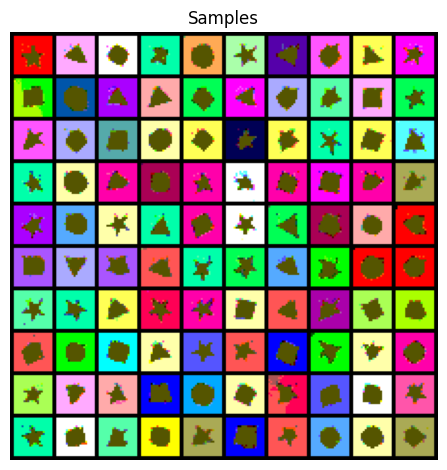

In [68]:
q3bc_save_results(1, 'b', q3_b)

Epoch 0, Test loss 0.1592
Epoch 1, Test loss 0.1123
Epoch 2, Test loss 0.0989
Epoch 3, Test loss 0.0955
Epoch 4, Test loss 0.0917
Epoch 5, Test loss 0.0888
Epoch 6, Test loss 0.0867
Epoch 7, Test loss 0.8351
Epoch 8, Test loss 0.5232
Epoch 9, Test loss 0.2045
Epoch 10, Test loss 0.1521
Epoch 11, Test loss 0.1182
Epoch 12, Test loss 0.1065
Epoch 13, Test loss 0.1005
Epoch 14, Test loss 0.0970
Final Test Loss: 0.0970


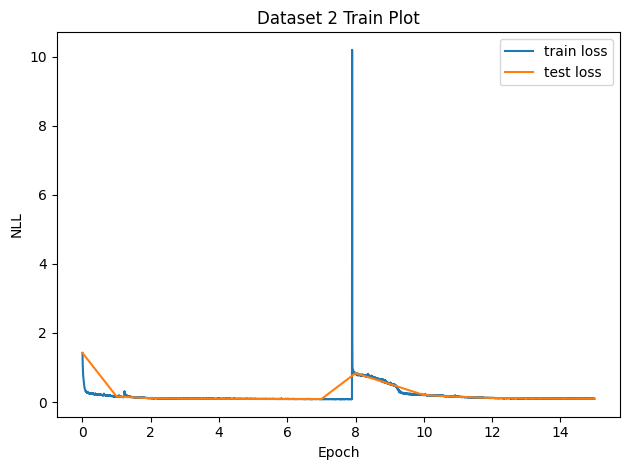

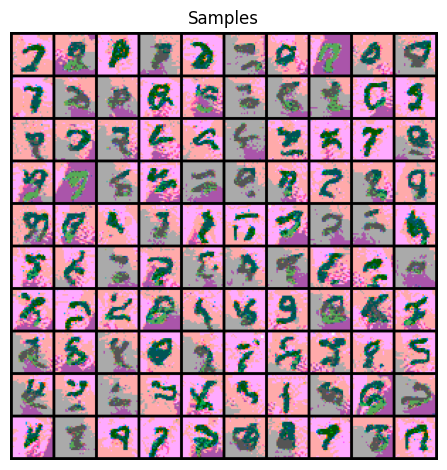

In [69]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, we will implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, we will change our masking scheme for the **center pixel**. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.


**Over the course of training, we will**


1.  Record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [108]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W, C = image_shape
    if dset_id == 1:
        model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, 
                         use_resblock=True, color_conditioning=True).cuda()
        train_args = dict(epochs=25, lr=1e-3, grad_clip=1)
    else:
        model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, 
                         use_resblock=True, color_conditioning=True).cuda()
        train_args=dict(epochs=25, lr=1e-3, grad_clip=1)

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)
    samples = model.sample_channel_dependent(100)
    return train_losses, test_losses, samples

Epoch 0, Test loss 0.1861
Epoch 1, Test loss 0.0903
Epoch 2, Test loss 0.0796
Epoch 3, Test loss 0.0537
Epoch 4, Test loss 0.0494
Epoch 5, Test loss 0.0419
Epoch 6, Test loss 0.0367
Epoch 7, Test loss 0.0314
Epoch 8, Test loss 0.0283
Epoch 9, Test loss 0.0280
Epoch 10, Test loss 0.0265
Epoch 11, Test loss 0.6792
Epoch 12, Test loss 0.1179
Epoch 13, Test loss 0.0661
Epoch 14, Test loss 0.0479
Epoch 15, Test loss 0.0390
Epoch 16, Test loss 0.0348
Epoch 17, Test loss 0.0325
Epoch 18, Test loss 0.0317
Epoch 19, Test loss 0.0303
Epoch 20, Test loss 0.0295
Epoch 21, Test loss 0.0292
Epoch 22, Test loss 0.0283
Epoch 23, Test loss 0.0278
Epoch 24, Test loss 0.0271
Final Test Loss: 0.0271


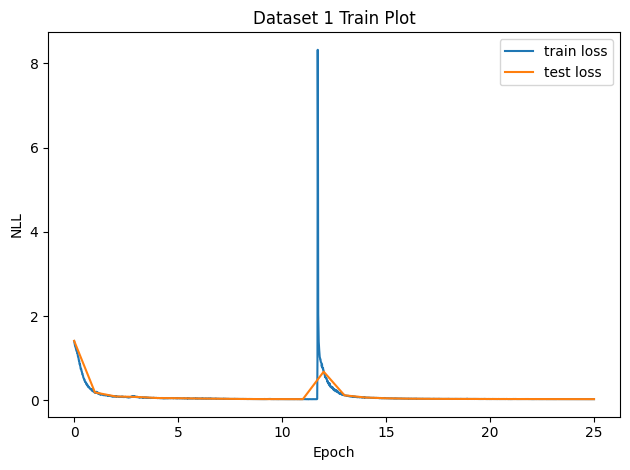

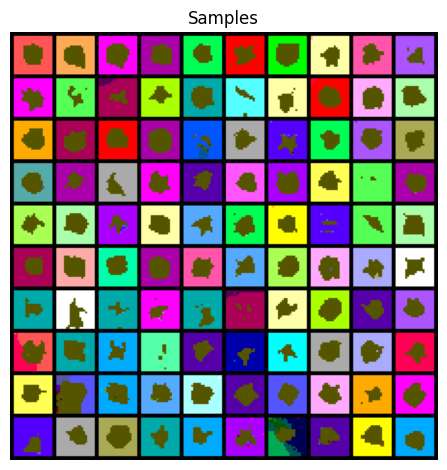

In [109]:
q3bc_save_results(1, 'c', q3_c)

Epoch 0, Test loss 0.1287
Epoch 1, Test loss 0.0720
Epoch 2, Test loss 0.0503
Epoch 3, Test loss 0.0433
Epoch 4, Test loss 0.2311
Epoch 5, Test loss 0.1250
Epoch 6, Test loss 0.0875
Epoch 7, Test loss 0.0662
Epoch 8, Test loss 0.0546
Epoch 9, Test loss 0.0481
Epoch 10, Test loss 0.0445
Epoch 11, Test loss 0.0418
Epoch 12, Test loss 0.0408
Epoch 13, Test loss 0.0390
Epoch 14, Test loss 0.0386
Epoch 15, Test loss 0.0379
Epoch 16, Test loss 0.0369
Epoch 17, Test loss 0.0363
Epoch 18, Test loss 0.0361
Epoch 19, Test loss 0.0354
Epoch 20, Test loss 0.0353
Epoch 21, Test loss 0.0348
Epoch 22, Test loss 0.0343
Epoch 23, Test loss 0.0340
Epoch 24, Test loss 0.0333
Final Test Loss: 0.0333


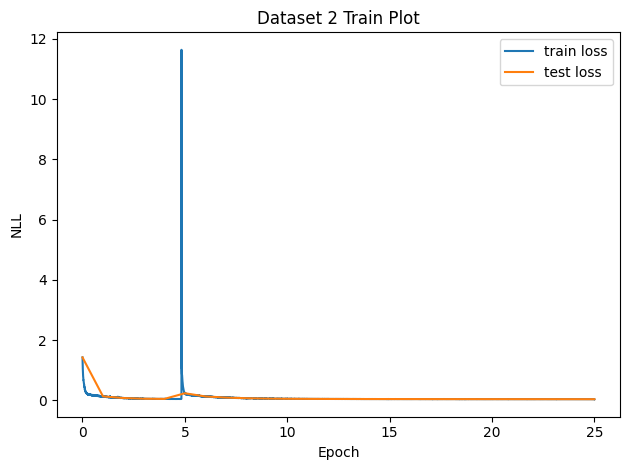

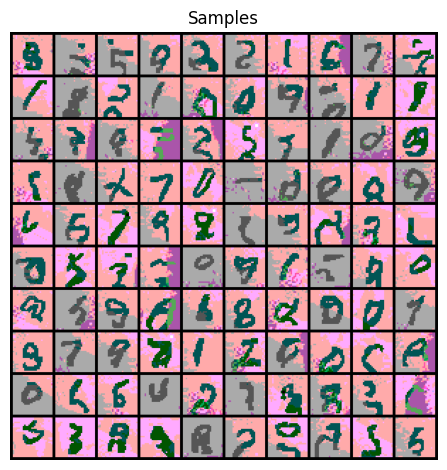

In [107]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, we will implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

We will use a PixelCNN architecture similar to part (a).

**Over the course of training we will**


1.  Record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.  Report the final test set performance of your final model
3. 100 samples from the final trained model

In [22]:
def preprocess_dset(data, labels, n_classes):
    data = np.transpose(data, (0, 3, 1, 2))
    labels_oh = np.zeros((len(labels), n_classes))
    labels_oh[np.arange(len(labels)), labels] = 1 # one hot encode
    labels_oh = labels_oh.astype('float32')
    return data, labels_oh

In [23]:
import torch.utils.data as data

class SimpleDataset(data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        loss = model.loss(x, cond=y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.cuda()
            y = y.cuda()
            loss = model.loss(x, cond=y)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss/len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [24]:

def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
    """
    train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
    train_labels: A (n_train,) numpy array of class labels, for shapes.pkl labesl are 0, 1, 2, 3 (total 4 shapes in th etrain dataset)
    test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
    test_labels: A (n_test,) numpy array of class labels
    image_shape: (H, W), height and width
    n_classes: number of classes (4 or 10)
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
    """

    train_data, train_labels_oh = preprocess_dset(train_data, train_labels, n_classes)
    test_data, test_labels_oh = preprocess_dset(test_data, test_labels, n_classes)

    H, W = image_shape # (28, 28) for mnist.pkl, (20, 20) for shapes.pkl
    
    # n_classes = 4 for shapes.pkl, 10 for mnist.pkl 
    model = PixelCNN((1, H, W), 2, conditional_size=(n_classes,)).cuda()

    train_loader = data.DataLoader(SimpleDataset(train_data, train_labels_oh), 
                                 batch_size=128, shuffle=True)
    test_loader = data.DataLoader(SimpleDataset(test_data, test_labels_oh), batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))

    cond = torch.arange(n_classes).unsqueeze(1).repeat(1, 100 // n_classes).view(-1).long() # 100 samples is equally distributes among different classes
    one_hot = torch.FloatTensor(cond.shape[0], n_classes) # float tensor of shape (100, n_classes) with random values
    one_hot.zero_() # fills self tensor with zeros
    
    # this fills the self tensor with values from src at indices specified by index for dim=dim
    # https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html
    # creates a tesnor of shape (100, n_classes) that corresponds to one hot encoded labels of cond
    one_hot.scatter_(1, cond.unsqueeze(1), 1) 

    one_hot = one_hot.cuda()

    samples = model.sample(100, cond=one_hot) # samples images depeedning based on class conditioning

    return train_losses, test_losses, samples

Final Test Loss: 0.0370


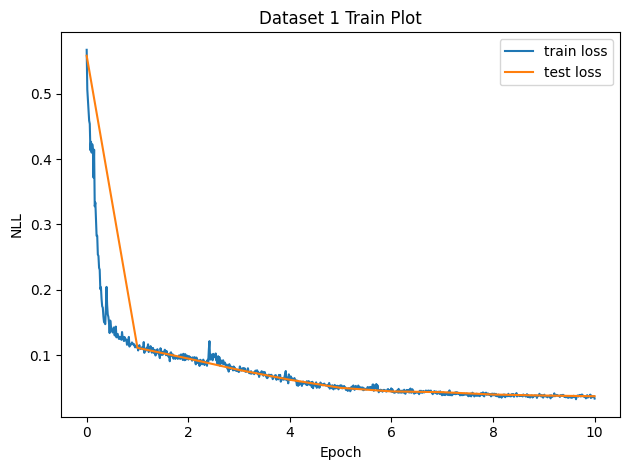

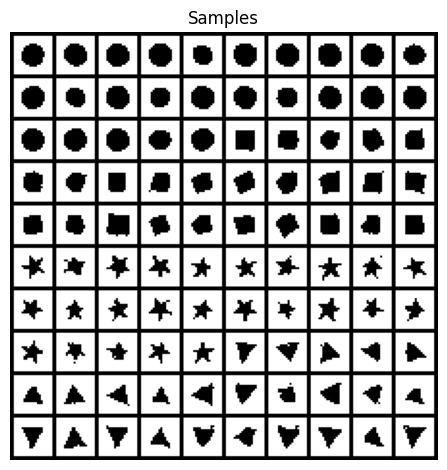

In [25]:
q3d_save_results(1, q3_d)

Final Test Loss: 0.0708


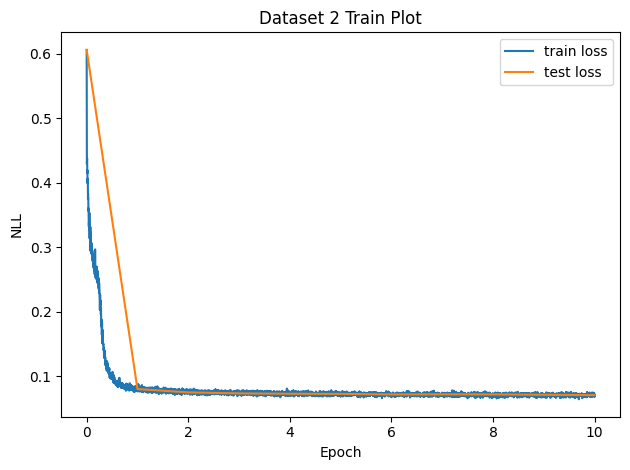

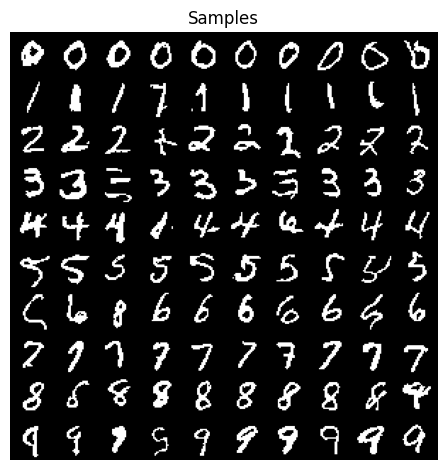

In [26]:
q3d_save_results(2, q3_d)

# Gated PixelCNN
We will implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

In [27]:
from tqdm import tqdm
quiet = False

def train(model, train_loader, optimizer, epoch, grad_clip=None):
    model.train()
  
    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    train_losses = []
    for x in train_loader:
        x = x.cuda().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip: # None https://jamesmccaffrey.wordpress.com/2022/10/17/the-difference-between-pytorch-clip_grad_value_-and-clip_grad_norm_-functions/
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())

        if not quiet:
            pbar.set_description(f'Epoch {epoch}, Train Loss {np.mean(train_losses[-50:]):.4f}')
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)

    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if not quiet:
            print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses

In [28]:
class StackLayerNorm(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.h_layer_norm = LayerNorm(False, n_filters)
        self.v_layer_norm = LayerNorm(False, n_filters)

    def forward(self, x):
        # does layer norm for the output of horizontal and vertical stack speerately
        vx, hx = x.chunk(2, dim=1)
        vx, hx = self.v_layer_norm(vx), self.h_layer_norm(hx)
        return torch.cat((vx, hx), dim=1)

class GatedConv2d(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, k=7, padding=3):
        super().__init__()
        
        # vertical stack - in_channels=64, out_channels=128, kernel_size = 7 x 7, padding to maintain spatial dim
        self.vertical = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=k,
                                  padding=padding, bias=False)
        
        # horizontal stack - in_channels=64, out_channels=128, kernel_size = 1 x 7, padding to maintain spatial dim
        self.horizontal = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=(1, k),
                                    padding=(0, padding), bias=False)
        
        # 1x1 conv to feed the info from vertical stack to horizontal stack
        # Note - since output of both horizontal and vertical stack has 128 channels, vtoh has in_channels and out_channels = 128
        self.vtoh = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1, 
                                bias=False)
        
        # 1x1 conv to for output of horizontal stack
        self.htoh = nn.Conv2d(out_channels, out_channels, kernel_size=1, 
                                bias=False)

        # masking for vertical and horizontal stack
        self.register_buffer('vmask', self.vertical.weight.data.clone()) #(128, 64, 7, 7)
        self.register_buffer('hmask', self.horizontal.weight.data.clone()) #(128, 64, 1, 7)
        
        # initially fill with all 1's
        self.vmask.fill_(1)
        self.hmask.fill_(1)

        # zero the bottom half rows of the vmask
        # No need for special color condition masking here since we get to see everything
        self.vmask[:, :, k // 2 :, :] = 0
        '''
        one channnel of self.vmask
        
        self.vmask
        [[1 1 1 1 1 1 1]
         [1 1 1 1 1 1 1]
         [1 1 1 1 1 1 1]
         [0 0 0 0 0 0 0]
         [0 0 0 0 0 0 0]
         [0 0 0 0 0 0 0]
         [0 0 0 0 0 0 0]]    
        '''
        

        # zero the right half of the hmask
        self.hmask[:, :, :, k // 2 + 1:] = 0 #(128, 64, 1, 7)
        '''
        one channel of self.hmask
        [[1 1 1 1 0 0 0]]
        '''
        
        if mask_type == 'A': # if zero t
            self.hmask[:, :, :, k // 2] = 0
  
    def down_shift(self, x):
        x = x[:, :, :-1, :]
        pad = nn.ZeroPad2d((0, 0, 1, 0))
        return pad(x)

    def forward(self, x):
        #x: (bs, ch, h, w) -> (128, 128, 28, 28)
        #  we split the input tensor into two across channels (both chunk are similar)
        # one chunk is used in vertical stack and the other in horizontal stack
        vx, hx = x.chunk(2, dim=1) #(128, 64, 28, 28), (128, 64, 28, 28)
        
        # apply masking before convolution
        self.vertical.weight.data *= self.vmask 
        self.horizontal.weight.data *= self.hmask
        
        # vertical stack convolution
        vx = self.vertical(vx) # (128, 128, 28, 28)
        # horizontal stack convoolution
        hx_new = self.horizontal(hx) # (128, 128, 28, 28)

        # Allow horizontal stack to see information from vertical stack via 1 x 1 conv
        hx_new = hx_new + self.vtoh(self.down_shift(vx)) 

        # Split input tensor into along channels to feed to the Gates
        vx_1, vx_2 = vx.chunk(2, dim=1) # (128, 64, 28, 28), (128, 64, 28, 28)
        vx = torch.tanh(vx_1) * torch.sigmoid(vx_2) # feed to diff gates and multiplying (128, 64, 28, 28)
        
        # same for horizontal stack
        hx_1, hx_2 = hx_new.chunk(2, dim=1)
        hx_new = torch.tanh(hx_1) * torch.sigmoid(hx_2) # 128, 64, 28, 28)
        
        # additionally pass the output to one more 1 x 1 convolution and add to the original input of the horizontal stack
        hx_new = self.htoh(hx_new)
        hx = hx + hx_new # (128, 64, 28, 28)
        
        # stack the output of horizontal and vertical stack across channels to feed as input to the next layer
        return torch.cat((vx, hx), dim=1) # (128, 128, 28, 28)

# GatedPixelCNN using horizontal and vertical stacks to fix blind-spot
class GatedPixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, n_layers=8, n_filters=120):
        super().__init__()
        self.n_channels = input_shape[0]
        self.n_colors = n_colors
        self.input_shape = input_shape
        
        # first layer is regular PixelCNN with type A conv - this emsuresthat there is no info flow from the pixel 
        # which we are trying to predict
        self.in_conv = MaskConv2d('A', self.n_channels, n_filters, 7, padding=3) 
        model = []
        
        # 6 layers of  GatedConv with type B Masking and LayerNorm across channels
        for _ in range(n_layers - 2):
            model.extend([nn.ReLU(), GatedConv2d('B', n_filters, n_filters, 7, padding=3)])
            model.append(StackLayerNorm(n_filters))
        
        # last layer is regular Type B conv
        # last conv layer outputs (bs, 12, 20, 20) where 12 is 3*4 -> represents the logit scores for 4 possible
        # pixel values at every pixel location at each channel
        self.out_conv = MaskConv2d('B', n_filters, n_colors * self.n_channels, 7, padding=3)
        self.net = nn.Sequential(*model)

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        out = self.in_conv(out)
        # the output of the network has shape (128, 128, 28, 28)
        # we split it into two across channels and take the second (128, 64, 28, 28) as the final output (from horizontal stack - also has info flow from vertocal stack)
        out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1]
        out = self.out_conv(out) # 128, 12, 28, 28)
        
        #(128, 3, 4, 28, 28)
        # last conv layer outputs (bs, 4, 3, 20, 20) where 4 represents the logit scores for four possible
        # pixel values at every pixel location
        return out.view(batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
  
    def loss(self, x):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    out = self(samples)
                    for k in range(self.n_channels):
                        # logits = self(samples)[:, :, k, r, c]
                        logits = out[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [29]:
import torch.utils.data as data


def q4_a(train_data, test_data, image_shape):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
    """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W, C = image_shape
    model = GatedPixelCNN((C, H, W), 4, n_filters=64, n_layers=8).cuda()
    train_args=dict(epochs=8, lr=1e-3, grad_clip=1)

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)
    samples = model.sample(100)
    return train_losses, test_losses, samples

In [30]:
q4a_save_results(q4_a)

Epoch 0, Train Loss 0.1884:  71%|███████▏  | 42880/60000 [03:02<01:12, 235.58it/s]

KeyboardInterrupt: 

Epoch 0, Train Loss 0.1884:  71%|███████▏  | 42880/60000 [03:20<01:12, 235.58it/s]